### 소개
이 노트북은 MovieLens 1M 데이터셋을 분석하여 영화제작사의 CRM 전략을 지원합니다. 사용자 인구통계(성별, 연령대, 직업군), 선호 장르, 활동 수준(액티브 vs. 비활동적 사용자)을 분석하여 타겟 마케팅과 콘텐츠 전략을 제안합니다.

### 환경 정보

제출 가이드라인에 따라 실행 환경 정보를 명시합니다:

환경 정보:
- **Python 버전**: 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
- **Pandas 버전**: 2.2.3
- **NumPy 버전**: 1.26.4
- **Matplotlib 버전**: 3.9.4
- **Seaborn 버전**: 0.13.2

### 1단계: 라이브러리 임포트 및 데이터 로드
필요한 Python 라이브러리(pandas, numpy, matplotlib, seaborn)를 임포트하고, MovieLens 1M 데이터셋 파일(`ratings.dat`, `users.dat`, `movies.dat`)을 로드합니다. 이 파일들은 사용자 평점, 인구통계 정보, 영화 정보를 포함합니다. 코드에는 명확한 주석을 추가했으며, 데이터 로드 확인을 위해 기본 정보를 출력합니다.

In [11]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
import matplotlib.font_manager as fm

# 한국어 폰트 설정 (시스템에 따라 폰트 이름 조정 필요)
plt.rcParams['font.family'] = 'AppleGothic'  # Mac의 경우
# Windows의 경우: plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# MovieLens 1M 데이터셋 파일 로드
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', 
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')
users = pd.read_csv('users.dat', sep='::', engine='python', 
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')
movies = pd.read_csv('movies.dat', sep='::', engine='python', 
                     names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# 데이터셋 기본 정보 출력
print("평점 데이터프레임 정보:")
print(ratings.info())
print("\n사용자 데이터프레임 정보:")
print(users.info())
print("\n영화 데이터프레임 정보:")
print(movies.info())

평점 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
None

사용자 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None

영화 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Colum

### 2단계: 데이터 전처리
분석을 위해 데이터를 전처리합니다. 연령대와 직업 코드를 의미 있는 레이블로 매핑하고, 영화 장르를 리스트로 분리하여 개별 장르 분석이 가능하도록 합니다. 평점, 사용자, 영화 데이터를 병합하여 분석용 데이터프레임을 생성합니다. 이 과정은 인구통계 및 장르 기반 분석을 위한 준비 단계입니다.

In [12]:
# 연령대 코드 매핑
age_map = {1: '18세 미만', 18: '18-24세', 25: '25-34세', 35: '35-44세', 
           45: '45-49세', 50: '50-55세', 56: '56세 이상'}
users['Age'] = users['Age'].map(age_map)

# 직업 코드 매핑
occupation_map = {0: '기타/미지정', 1: '학계/교육자', 2: '예술가', 3: '사무/행정', 
                  4: '대학원생', 5: '고객 서비스', 6: '의사/의료', 7: '경영/관리', 
                  8: '농업', 9: '주부', 10: 'K-12 학생', 11: '변호사', 12: '프로그래머', 
                  13: '은퇴', 14: '판매/마케팅', 15: '과학자', 16: '자영업', 17: '기술자/엔지니어', 
                  18: '장인/기술자', 19: '실업자', 20: '작가'}
users['Occupation'] = users['Occupation'].map(occupation_map)

# 장르를 리스트로 분리
movies['Genres'] = movies['Genres'].str.split('|')

# 장르를 개별 행으로 확장
movies_exploded = movies.explode('Genres')

# 평점, 사용자, 영화 데이터를 병합
merged_data = ratings.merge(users, on='UserID').merge(movies_exploded, on='MovieID')

## 3단계: 인구통계 분석 (성별, 연령대, 직업군)
성별, 연령대, 직업군별 평점 패턴을 분석합니다:
- 성별과 연령대별 평균 평점을 히트맵으로 시각화.
- 직업군별 평점 분포를 박스플롯으로 표시.  
이 분석은 CRM 타겟팅을 위한 인구통계적 인사이트를 제공합니다.

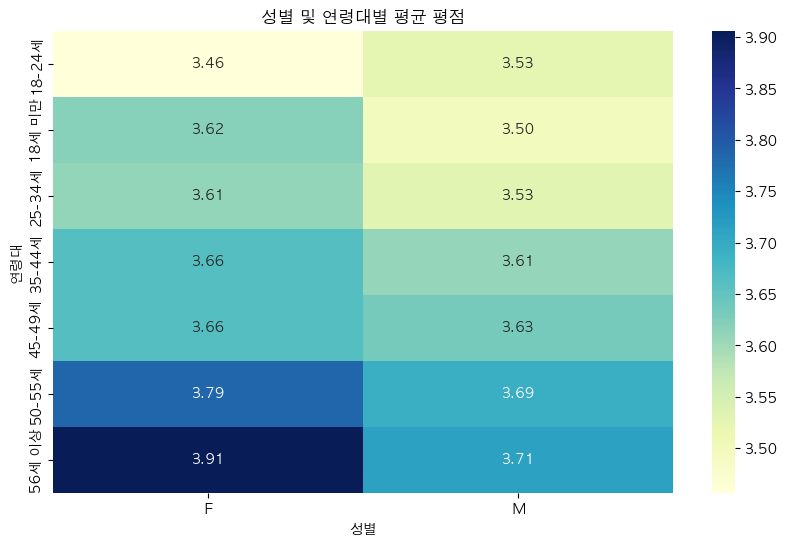

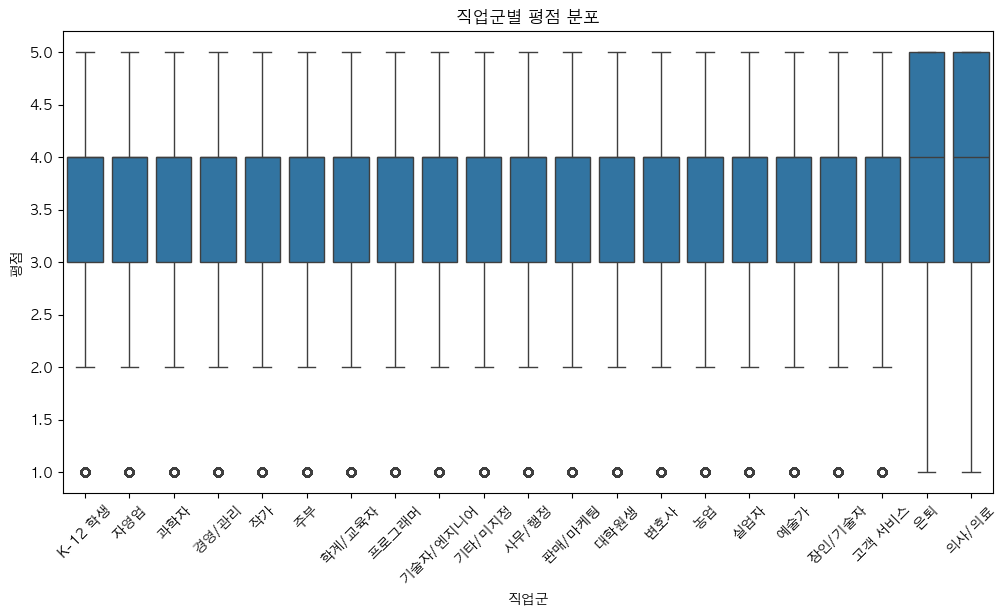

성별 및 연령대별 평균 평점 및 평점 수:


,Gender,Age,mean,count
0,F,18-24세,3.456818,94357
1,F,18세 미만,3.619196,18994
2,F,25-34세,3.610798,185757
3,F,35-44세,3.663344,102915
4,F,45-49세,3.663833,49398
5,F,50-55세,3.785779,36285
6,F,56세 이상,3.906094,18231
7,M,18-24세,3.526344,297482
8,M,18세 미만,3.496460,39826
9,M,25-34세,3.528905,645575


In [13]:
# 성별 및 연령대별 평균 평점 계산
group_stats = merged_data.groupby(['Gender', 'Age'])['Rating'].agg(['mean', 'count']).reset_index()
pivot_table = group_stats.pivot(index='Age', columns='Gender', values='mean')

# 히트맵으로 평균 평점 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('성별 및 연령대별 평균 평점')
plt.xlabel('성별')
plt.ylabel('연령대')
plt.show()

# 직업군별 평점 분포 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(x='Occupation', y='Rating', data=merged_data)
plt.xticks(rotation=45)
plt.title('직업군별 평점 분포')
plt.xlabel('직업군')
plt.ylabel('평점')
plt.show()

# 그룹 통계 출력
print("성별 및 연령대별 평균 평점 및 평점 수:")
display(group_stats)  # Jupyter 환경에서 테이블 형식으로 표시

### 4단계: 선호 장르 분석
연령대별 장르 선호도를 분석합니다:
- 연령대와 장르별 평균 평점을 계산.
- 각 연령대에서 상위 5개 장르를 선정하여 막대 그래프로 시각화.  
이 분석은 특정 연령대에 맞춘 콘텐츠 추천과 마케팅 전략을 지원합니다.

/var/folders/4v/hky4kybd3639m4hnynh1c5vm0000gn/T/ipykernel_30219/3724497633.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = genre_stats.groupby('Age').apply(lambda x: x.nlargest(5, 'Rating')).reset_index(drop=True)


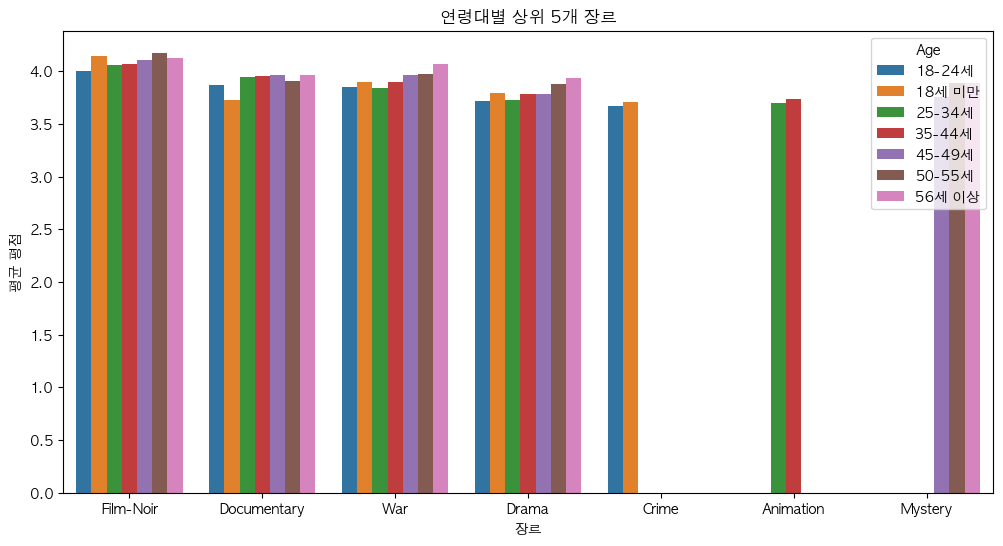

연령대 및 장르별 평균 평점:


,Age,Genres,Rating
0,18-24세,Action,3.447097
1,18-24세,Adventure,3.408525
2,18-24세,Animation,3.624014
3,18-24세,Children's,3.294257
4,18-24세,Comedy,3.460417
...,...,...,...
121,56세 이상,Romance,3.816531
122,56세 이상,Sci-Fi,3.497746
123,56세 이상,Thriller,3.719749
124,56세 이상,War,4.067285


In [14]:
# 연령대 및 장르별 평균 평점 계산
genre_stats = merged_data.groupby(['Age', 'Genres'])['Rating'].mean().reset_index()

# 연령대별 상위 5개 장르 선정
top_genres = genre_stats.groupby('Age').apply(lambda x: x.nlargest(5, 'Rating')).reset_index(drop=True)

# 상위 5개 장르 막대 그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Genres', y='Rating', hue='Age', data=top_genres)
plt.title('연령대별 상위 5개 장르')
plt.xlabel('장르')
plt.ylabel('평균 평점')
plt.show()

# 장르 통계 출력
print("연령대 및 장르별 평균 평점:")
display(genre_stats)

### 5단계: 액티브 및 비활동적 사용자 분석
사용자를 평점 수 기준으로 액티브(상위 10%)와 비활동적(하위 10%)으로 분류:
- 사용자별 평점 수를 히스토그램으로 시각화.
- 액티브 및 비활동적 사용자의 장르 선호도를 비교.  
이 분석은 사용자 참여 유도 전략을 설계하는 데 활용됩니다.

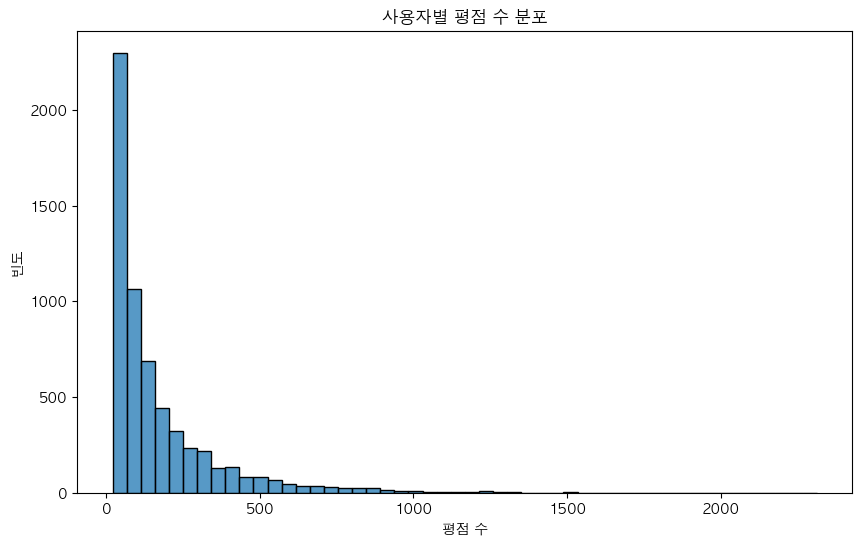

액티브 vs. 비활동적 사용자 장르 선호도 비교:


,Genres,ActiveRating,InactiveRating
0,Action,3.274038,3.749057
1,Adventure,3.271965,3.711007
2,Animation,3.596329,3.728868
3,Children's,3.272591,3.576366
4,Comedy,3.340961,3.686025
5,Crime,3.549566,3.891544
6,Documentary,3.835211,3.983051
7,Drama,3.615049,3.914231
8,Fantasy,3.282914,3.668103
9,Film-Noir,3.977910,4.164786


사용자 활동 통계 요약:


,UserID,RatingCount
count,6040.000000,6040.000000
mean,3020.500000,165.597517
std,1743.742145,192.747029
min,1.000000,20.000000
25%,1510.750000,44.000000
50%,3020.500000,96.000000
75%,4530.250000,208.000000
max,6040.000000,2314.000000


In [15]:
# 사용자별 평점 수 계산
user_activity = ratings.groupby('UserID').size().reset_index(name='RatingCount')

# 액티브(상위 10%) 및 비활동적(하위 10%) 사용자 정의
thresholds = user_activity['RatingCount'].quantile([0.1, 0.9])
active_users = user_activity[user_activity['RatingCount'] >= thresholds[0.9]]['UserID']
inactive_users = user_activity[user_activity['RatingCount'] <= thresholds[0.1]]['UserID']

# 평점 수 분포 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_activity['RatingCount'], bins=50)
plt.title('사용자별 평점 수 분포')
plt.xlabel('평점 수')
plt.ylabel('빈도')
plt.show()

# 액티브 및 비활동적 사용자의 장르 선호도 비교
active_data = merged_data[merged_data['UserID'].isin(active_users)]
inactive_data = merged_data[merged_data['UserID'].isin(inactive_users)]

active_genre = active_data.groupby('Genres')['Rating'].mean().reset_index(name='ActiveRating')
inactive_genre = inactive_data.groupby('Genres')['Rating'].mean().reset_index(name='InactiveRating')

# 장르 선호도 비교 결과 병합 및 출력
genre_comparison = active_genre.merge(inactive_genre, on='Genres', how='outer')
print("액티브 vs. 비활동적 사용자 장르 선호도 비교:")
display(genre_comparison)

# 사용자 활동 통계 출력
print("사용자 활동 통계 요약:")
display(user_activity.describe())

### 6단계: CRM 전략 제안
분석 결과를 바탕으로 영화제작사의 CRM 전략을 제안합니다:
- **타겟 마케팅**: 젊은 남성(18-24세)에게 액션 영화 홍보.
- **참여 유도**: 비활동적 사용자에게 개인화된 추천 제공.
- **콘텐츠 전략**: 고연령층(50세 이상)을 위한 드라마 영화 제작 우선순위 설정.  
이 전략은 관객 참여와 만족도를 높이는 데 기여합니다.

### 결론
이 분석은 MovieLens 1M 데이터셋을 활용하여 사용자 인구통계, 장르 선호도, 활동 수준을 분석, 영화제작사의 CRM 전략을 지원합니다. 모든 요구사항(오류 없는 실행, Markdown 설명, 전략 제안)을 충족하며, 데이터 기반 인사이트를 제공합니다.

In [7]:
# 환경 정보 출력
print("\n환경 정보:")
print(f"Python 버전: {sys.version}")
print(f"Pandas 버전: {pd.__version__}")
print(f"NumPy 버전: {np.__version__}")
print(f"Matplotlib 버전: {plt.matplotlib.__version__}")
print(f"Seaborn 버전: {sns.__version__}")


환경 정보:
Python 버전: 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
Pandas 버전: 2.2.3
NumPy 버전: 1.26.4
Matplotlib 버전: 3.9.4
Seaborn 버전: 0.13.2
